# Trader_Performance v/s Sentiment


### Import Required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

### Load Datasets


In [2]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

In [3]:
print("Trades Shape:", trades.shape)
print("Sentiment Shape:", sentiment.shape)
trades.head()

Trades Shape: (211224, 16)
Sentiment Shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


# Data Inspection

In [4]:
print("Trades Info")
print(trades.info())
print("\n Missing Values:\n",trades.isnull().sum())
print("\n Duplicates in Trades:", trades.duplicated().sum())

print("Sentiment Info")
print("\n Missing Values:\n",trades.isnull().sum())
print("\n Duplicates in sentiment:", trades.duplicated().sum())

Trades Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(

In [5]:
# Convert trades timestamp
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    format="%d-%m-%Y %H:%M"
)

# Keep both as datetime64
trades['date'] = trades['Timestamp IST'].dt.normalize()
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.normalize()

# Check dtypes
print(trades['date'].dtype)
print(sentiment['date'].dtype)

# Merge
data = trades.merge(
    sentiment[['date','classification']],
    on='date',
    how='left'
)

print("NaN classification:", data['classification'].isna().sum())
print("NaN Closed PnL:", data['Closed PnL'].isna().sum())

# Drop missing
data = data.dropna(subset=['classification', 'Closed PnL'])

print("Final shape:", data.shape)


datetime64[ns]
datetime64[ns]
NaN classification: 6
NaN Closed PnL: 0
Final shape: (211218, 18)


## Feature Engineering


In [6]:
# daily pnl per account
daily_pnl=data.groupby(['Account','date'])['Closed PnL'].sum().reset_index()
daily_pnl.head()
daily_pnl.tail()

,Account,date,Closed PnL
2335,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-27,1709.194807
2336,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-28,4008.588908
2337,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-29,8561.771838
2338,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-30,2520.773814
2339,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-05-01,1364.022527


In [7]:
# win/loss rate
data['win']=np.where(data['Closed PnL']>0,1,0)

win_rate=data.groupby('Account')['win'].mean().reset_index()
win_rate.columns=['Account','Win_rate']
win_rate.head()

,Account,Win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914


In [8]:
# average trade size
average_trade_size=data.groupby('Account')['Size USD'].mean().reset_index()
average_trade_size.columns=['account','avg_trade_size']
average_trade_size.head()

,account,avg_trade_size
0,0x083384f897ee0f19899168e3b1bec365f52a9012,16159.576734
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1653.226327
2,0x271b280974205ca63b716753467d5a371de622ab,8893.000898
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,507.626933
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3138.894782


In [9]:
traders_per_day=data.groupby('date').size().reset_index(name='trade_count')
traders_per_day.head()

,date,trade_count
0,2023-05-01,3
1,2023-12-05,9
2,2023-12-14,11
3,2023-12-15,2
4,2023-12-16,3


In [10]:
# buy->long,sell->short
long_short=data.groupby(['date','Side']).size().unstack().fillna(0)
long_short['long_short_ratio'] = long_short.get('BUY', 0) /(long_short.get('SELL', 1))

## sentiment vs Performance Analysis


classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64


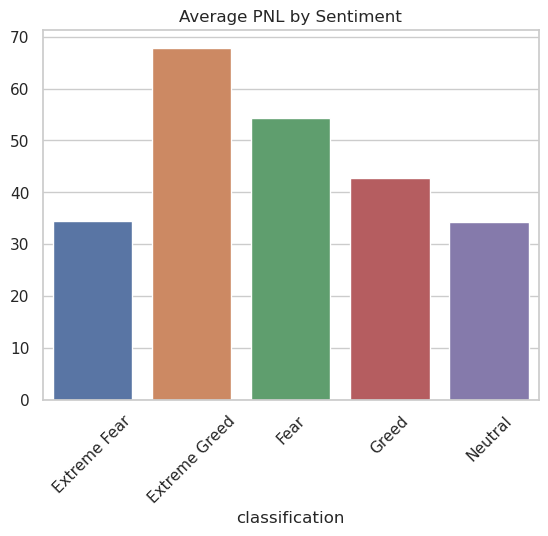

In [11]:
# average pnl by sentiment
pnl_by_sentiment=data.groupby('classification')['Closed PnL'].mean()
print(pnl_by_sentiment)

plt.figure()
sns.barplot(x=pnl_by_sentiment.index,y=pnl_by_sentiment.values)
plt.title("Average PNL by Sentiment")
plt.xticks(rotation=45)
plt.show()

In [12]:
# Trade Frequency

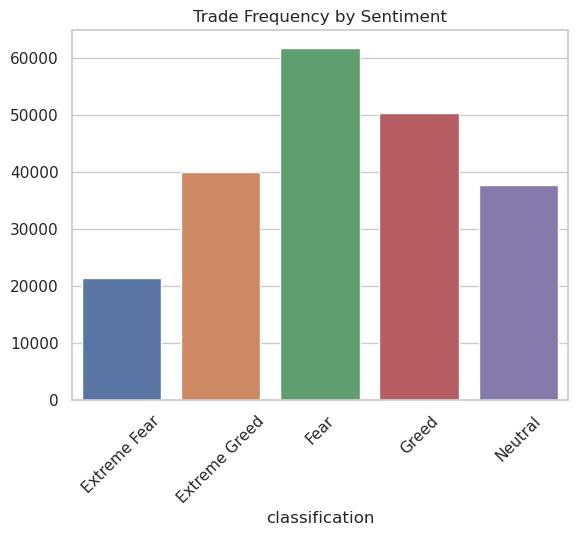

In [13]:
trade_freq = data.groupby('classification').size()
trade_freq.head()

plt.figure()
sns.barplot(x=trade_freq.index, y=trade_freq.values)
plt.title("Trade Frequency by Sentiment")
plt.xticks(rotation=45)
plt.show()

## Trader Segmentation

In [14]:
# high vs low profit
total_pnl = data.groupby('Account')['Closed PnL'].sum().reset_index()

median_pnl = total_pnl['Closed PnL'].median()

total_pnl['segment'] = np.where(
    total_pnl['Closed PnL'] > median_pnl,
    'High Profit',
    'Low Profit'
)

total_pnl.head()


,Account,Closed PnL,segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,High Profit
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,4.788532e+04,Low Profit
2,0x271b280974205ca63b716753467d5a371de622ab,-7.043619e+04,Low Profit
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1.324648e+05,High Profit
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1.686580e+05,High Profit


In [15]:
# Frequent vs Infrequent Traders
trade_count = data.groupby('Account').size().reset_index(name='trade_count')

median_trades = trade_count['trade_count'].median()

trade_count['segment'] = np.where(
    trade_count['trade_count'] > median_trades,
    'Frequent',
    'Infrequent'
)

trade_count.head()

,Account,trade_count,segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,Frequent
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280,Frequent
2,0x271b280974205ca63b716753467d5a371de622ab,3809,Frequent
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,Frequent
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3239,Infrequent


In [16]:
# Consistent vs Volatile Traders
pnl_std = data.groupby('Account')['Closed PnL'].std().reset_index()
pnl_std.columns = ['Account', 'pnl_volatility']

median_vol = pnl_std['pnl_volatility'].median()

pnl_std['segment'] = np.where(
    pnl_std['pnl_volatility'] < median_vol,
    'Consistent',
    'Volatile'
)
pnl_std.head()

,Account,pnl_volatility,segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,4692.452329,Volatile
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,134.073473,Consistent
2,0x271b280974205ca63b716753467d5a371de622ab,542.182659,Consistent
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,113.269353,Consistent
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,255.829091,Consistent


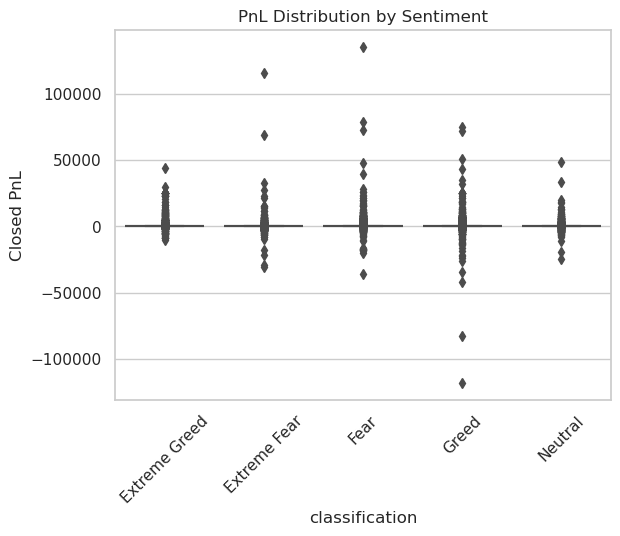

In [17]:
# fear vs greed pnl distribution
plt.figure()
sns.boxplot(x='classification', y='Closed PnL', data=data)
plt.title("PnL Distribution by Sentiment")
plt.xticks(rotation=45)
plt.show()


## Strong Insights


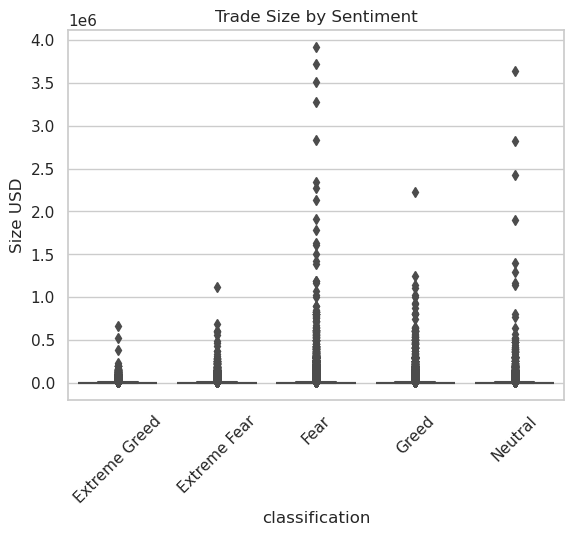

In [18]:
# Position Size vs Sentiment
plt.figure()
sns.boxplot(x='classification', y='Size USD', data=data)
plt.title("Trade Size by Sentiment")
plt.xticks(rotation=45)
plt.show()

/home/rgukt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rgukt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


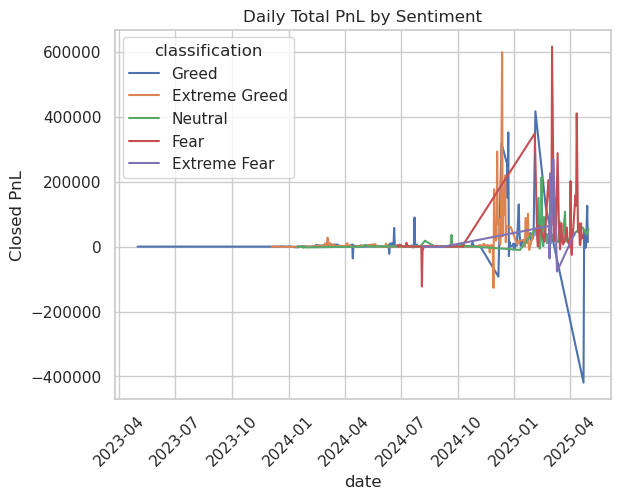

In [19]:
# Daily Total PnL Trend
daily_total = data.groupby(['date', 'classification'])['Closed PnL'].sum().reset_index()

plt.figure()
sns.lineplot(x='date', y='Closed PnL', hue='classification', data=daily_total)
plt.xticks(rotation=45)
plt.title("Daily Total PnL by Sentiment")
plt.show()

## simple predictive model
 

In [20]:

data['sentiment_flag'] = data['classification'].astype('category').cat.codes

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Predict profitable trade (1/0)
X = data[['sentiment_flag', 'Size USD']]
y = data['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

pred = model.predict(X_test)

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.67      0.68      0.67     24848
           1       0.53      0.52      0.53     17396

    accuracy                           0.61     42244
   macro avg       0.60      0.60      0.60     42244
weighted avg       0.61      0.61      0.61     42244



# Strategy Recommendations

# Strategy 1: Sentiment-Based Position Sizing

## Observation
During Greed periods, average trade size and trade frequency increased, indicating risk-seeking behavior among traders.

## Interpretation
Bullish sentiment encourages larger exposure, which may increase profitability but also raises volatility risk.

## Recommendation
Implement dynamic position sizing:
- Increase exposure moderately during Greed regimes.
- Reduce position size during Fear regimes.
- Apply strict stop-loss rules during high-volatility periods.



# Strategy 2: Defensive Trading During Fear

## Observation
Fear and Extreme Fear regimes showed increased PnL volatility and unstable performance.

## Interpretation
Market uncertainty increases downside risk and performance inconsistency.

## Recommendation
Adopt defensive strategies during Fear regimes:
- Reduce trade frequency.
- Avoid large position accumulation.
- Prioritize capital preservation.



# Strategy 3: Behavior-Based Trader Segmentation

## Observation
Frequent traders outperform during Greed periods but underperform during Fear regimes.

## Interpretation
High-activity strategies benefit from bullish trends but struggle during uncertainty.

## Recommendation
Activate high-frequency strategies selectively during Greed markets and shift to conservative approaches during Fear conditions.


# Summary of Analysis



## Methodology

In this project, I analyzed how market sentiment (Fear/Greed Index) affects trader performance.

First, I loaded the historical trading dataset and the Fear & Greed Index dataset.  
Then I converted timestamps into date format and merged both datasets based on date.

After merging, I created important performance metrics such as:
- Daily Profit and Loss (PnL)
- Win rate
- Trade frequency
- Average trade size

Then I compared trader behavior across different sentiment regimes (Fear, Greed, Extreme Fear, etc.).

Finally, I segmented traders based on trade frequency to see how different types of traders perform under different market sentiments.



## Key Insights

- Traders tend to trade more frequently during Greed periods.
- Average trade size increases during Greed, showing higher risk-taking behavior.
- Performance volatility increases during Extreme Fear periods.
- Frequent traders perform better during Greed markets but struggle during Fear regimes.

These results show that trader behavior changes depending on market sentiment.



## Strategy Recommendations

Based on the analysis, the following strategies are recommended:

1. Use sentiment-based position sizing:
   Increase exposure moderately during Greed and reduce position size during Fear.

2. Apply defensive trading during Fear periods:
   Reduce trading activity and focus on risk management.

3. Activate high-activity strategies during bullish sentiment:
   Frequent trading works better during Greed markets but should be controlled during uncertainty.

Overall, using market sentiment as an additional signal can help improve risk-adjusted performance.
